In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.join('../'))))

import umap
import tqdm
import numpy
import itertools
import torchvision
import gtda.images
import gtda.diagrams
import gtda.homology
import sklearn.pipeline
import sklearn.ensemble
import sklearn.metrics
import sklearn.neighbors
import tqdm.contrib.itertools
import sklearn.decomposition

import cvtda.topology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BINARIZATION_THESHOLD = 0.2

height_filtration_directions = [
    [ -1, -1 ], [ 1, 1 ], [ 1, -1 ], [ -1, 1 ],
    [ 0, -1 ], [ 0, 1 ], [ -1, 0 ], [ 1, 0 ]
]


radial_filtration_centers = list(itertools.product([ 7, 14, 21 ], [ 7, 14, 21 ]))
radial_filtration_metrics = [ "euclidean", "manhattan", "cosine" ]

density_filtration_metrics = [ "euclidean" , "manhattan", "cosine" ]
density_filtration_radiuses = [ 1, 5, 15 ]

FILTRATIONS = [
    *[ [ gtda.images.HeightFiltration, { 'direction': numpy.array(direction), 'n_jobs': -1 } ] for direction in height_filtration_directions ],
    *[
        [ gtda.images.RadialFiltration, { 'center': numpy.array(center), 'metric': metric, 'n_jobs': -1 } ]
        for center in radial_filtration_centers
        for metric in radial_filtration_metrics
    ],
    [ gtda.images.DilationFiltration, { 'n_jobs': -1 } ],
    [ gtda.images.ErosionFiltration, { 'n_jobs': -1 } ],
    [ gtda.images.SignedDistanceFiltration, { 'n_jobs': -1 } ],
    *[
        [ gtda.images.DensityFiltration, { 'radius': radius, 'metric': metric, 'n_jobs': -1 } ]
        for metric in density_filtration_metrics
        for radius in density_filtration_radiuses
    ]
]

In [5]:
train = torchvision.datasets.MNIST('mnist', train = True, download = True)
test = torchvision.datasets.MNIST('mnist', train = False, download = True)

train_images = numpy.array([ item[0] for item in train ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ item[0] for item in test ])
test_labels = numpy.array([ item[1] for item in test ])

In [6]:
def make_filtrations(images: numpy.ndarray):
    images_bin = gtda.images.Binarizer(threshold = BINARIZATION_THESHOLD).fit_transform(images)
    filtrations = [
        filtration[0](**filtration[1]).fit_transform(images_bin)
        for filtration in tqdm.tqdm(FILTRATIONS, desc = 'filtrations')
    ]
    return [ images, images_bin ] + filtrations


def make_point_clouds(images: numpy.ndarray):
    def make_point_cloud(image, threshold):
        point_cloud = [ ]
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i][j] < threshold:
                    continue
                point_cloud.append([ i, j, image[i][j] ])
        return numpy.array(point_cloud)

    def _make_point_clouds(imgs, threshold):
        imgs = numpy.swapaxes(numpy.flip(imgs, axis = 1), 1, 2)
        return [ make_point_cloud(image, threshold) for image in tqdm.tqdm(imgs, desc = 'point_clouds') ]

    images_bin = gtda.images.Binarizer(threshold = BINARIZATION_THESHOLD).fit_transform(images)
    point_cloud = gtda.images.ImageToPointCloud().fit_transform(images_bin)
    return [ point_cloud, _make_point_clouds(images, 50) ]

In [7]:
def make_filtration_diagrams(images: numpy.ndarray):
    filtrations = make_filtrations(images)
    all_filtrations = [ ]
    for diagrams in zip(*filtrations):
        all_filtrations.extend(diagrams)

    print('Making filtration diagrams')
    persistence = gtda.homology.CubicalPersistence(homology_dimensions = [ 0, 1 ], n_jobs = -1)
    return persistence.fit_transform(all_filtrations)

def make_point_cloud_diagrams(images: numpy.ndarray):
    point_clouds = make_point_clouds(images)
    all_point_clouds = [ ]
    for diagrams in zip(*point_clouds):
        all_point_clouds.extend(diagrams)
        
    print('Making point cloud diagrams')
    persistence = gtda.homology.VietorisRipsPersistence(homology_dimensions = [ 0, 1, 2 ], n_jobs = -1)
    return persistence.fit_transform(all_point_clouds)

In [9]:
train_filtration_diagrams = make_filtration_diagrams(train_images)
numpy.save("4__train_filtration_diagrams.npy", train_filtration_diagrams)

train_filtration_diagrams = numpy.load("4__train_filtration_diagrams.npy")
train_filtration_diagrams.shape

filtrations: 100%|██████████| 47/47 [04:38<00:00,  5.93s/it]


Making filtration diagrams


(2940000, 80, 3)

In [10]:
train_pointcloud_diagrams = make_point_cloud_diagrams(train_images)
numpy.save("4__train_pointcloud_diagrams.npy", train_pointcloud_diagrams)

train_pointcloud_diagrams = numpy.load("4__train_pointcloud_diagrams.npy")
train_pointcloud_diagrams.shape

point_clouds: 100%|██████████| 60000/60000 [00:46<00:00, 1291.65it/s]


Making point cloud diagrams


(120000, 665, 3)

In [8]:
test_filtration_diagrams = make_filtration_diagrams(test_images)
numpy.save("4__test_filtration_diagrams.npy", test_filtration_diagrams)

test_filtration_diagrams = numpy.load("4__test_filtration_diagrams.npy")
test_filtration_diagrams.shape

filtrations: 100%|██████████| 47/47 [00:48<00:00,  1.04s/it]


Making filtration diagrams


(490000, 72, 3)

In [12]:
test_pointcloud_diagrams = make_point_cloud_diagrams(test_images)
numpy.save("4__test_pointcloud_diagrams.npy", test_pointcloud_diagrams)

test_pointcloud_diagrams = numpy.load("4__test_pointcloud_diagrams.npy")
test_pointcloud_diagrams.shape

point_clouds: 100%|██████████| 10000/10000 [00:07<00:00, 1301.70it/s]


Making point cloud diagrams


(20000, 545, 3)

In [13]:
def calculate_features(diagrams: numpy.ndarray, N: int = 122500):
    features = None
    for i in range(0, len(diagrams), N):
        print(f'Calculating {i} - {i + N}')
        feature_calculator = lib.topology.FeatureCalculator(n_jobs = -1, verbose = True)
        batch = feature_calculator.calc_features(diagrams[i:i + N])
        if features is None:
            features = batch
        else:
            features = numpy.concatenate((features, batch), axis = 0)
    return features

In [14]:
train_filtration_features = calculate_features(train_filtration_diagrams)
numpy.save("4__train_filtration_features.npy", train_filtration_features)

train_filtration_features = numpy.load("4__train_filtration_features.npy")
train_filtration_features.shape

Calculating 0 - 122500
Filtered diagrams: (122500, 71, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [02:01<00:00,  5.77s/it]


Calculating lifetime features
Calculating 122500 - 245000
Filtered diagrams: (122500, 53, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:48<00:00,  5.18s/it]


Calculating lifetime features
Calculating 245000 - 367500
Filtered diagrams: (122500, 73, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:54<00:00,  5.44s/it]


Calculating lifetime features
Calculating 367500 - 490000
Filtered diagrams: (122500, 69, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:46<00:00,  5.08s/it]


Calculating lifetime features
Calculating 490000 - 612500
Filtered diagrams: (122500, 76, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:55<00:00,  5.51s/it]


Calculating lifetime features
Calculating 612500 - 735000
Filtered diagrams: (122500, 62, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:48<00:00,  5.18s/it]


Calculating lifetime features
Calculating 735000 - 857500
Filtered diagrams: (122500, 52, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:42<00:00,  4.87s/it]


Calculating lifetime features
Calculating 857500 - 980000
Filtered diagrams: (122500, 58, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:45<00:00,  5.03s/it]


Calculating lifetime features
Calculating 980000 - 1102500
Filtered diagrams: (122500, 50, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:36<00:00,  4.60s/it]


Calculating lifetime features
Calculating 1102500 - 1225000
Filtered diagrams: (122500, 62, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:46<00:00,  5.08s/it]


Calculating lifetime features
Calculating 1225000 - 1347500
Filtered diagrams: (122500, 52, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:38<00:00,  4.68s/it]


Calculating lifetime features
Calculating 1347500 - 1470000
Filtered diagrams: (122500, 68, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:51<00:00,  5.30s/it]


Calculating lifetime features
Calculating 1470000 - 1592500
Filtered diagrams: (122500, 59, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:48<00:00,  5.16s/it]


Calculating lifetime features
Calculating 1592500 - 1715000
Filtered diagrams: (122500, 47, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:35<00:00,  4.56s/it]


Calculating lifetime features
Calculating 1715000 - 1837500
Filtered diagrams: (122500, 73, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:55<00:00,  5.51s/it]


Calculating lifetime features
Calculating 1837500 - 1960000
Filtered diagrams: (122500, 58, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:45<00:00,  5.04s/it]


Calculating lifetime features
Calculating 1960000 - 2082500
Filtered diagrams: (122500, 60, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:47<00:00,  5.10s/it]


Calculating lifetime features
Calculating 2082500 - 2205000
Filtered diagrams: (122500, 49, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:40<00:00,  4.77s/it]


Calculating lifetime features
Calculating 2205000 - 2327500
Filtered diagrams: (122500, 77, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:56<00:00,  5.55s/it]


Calculating lifetime features
Calculating 2327500 - 2450000
Filtered diagrams: (122500, 63, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:51<00:00,  5.29s/it]


Calculating lifetime features
Calculating 2450000 - 2572500
Filtered diagrams: (122500, 60, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:43<00:00,  4.95s/it]


Calculating lifetime features
Calculating 2572500 - 2695000
Filtered diagrams: (122500, 72, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:50<00:00,  5.25s/it]


Calculating lifetime features
Calculating 2695000 - 2817500
Filtered diagrams: (122500, 69, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:48<00:00,  5.18s/it]


Calculating lifetime features
Calculating 2817500 - 2940000
Filtered diagrams: (122500, 50, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Calculating lifetime features


(2940000, 172)

In [18]:
train_pointcloud_features = calculate_features(train_pointcloud_diagrams, N = 30625)
numpy.save("4__train_pointcloud_features.npy", train_pointcloud_features)

train_pointcloud_features = numpy.load("4__train_pointcloud_features.npy")
train_pointcloud_features.shape

Calculating 0 - 30625
Filtered diagrams: (30625, 339, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:42<00:00,  4.88s/it]


Calculating lifetime features
Calculating 30625 - 61250
Filtered diagrams: (30625, 356, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:46<00:00,  5.08s/it]


Calculating lifetime features
Calculating 61250 - 91875
Filtered diagrams: (30625, 384, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:50<00:00,  5.28s/it]


Calculating lifetime features
Calculating 91875 - 122500
Filtered diagrams: (28125, 350, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:39<00:00,  4.76s/it]


Calculating lifetime features


(120000, 231)

In [19]:
test_filtration_features = calculate_features(test_filtration_diagrams)
numpy.save("4__test_filtration_features.npy", test_filtration_features)

test_filtration_features = numpy.load("4__test_filtration_features.npy")
test_filtration_features.shape

Calculating 0 - 122500
Filtered diagrams: (122500, 54, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:45<00:00,  5.04s/it]


Calculating lifetime features
Calculating 122500 - 245000
Filtered diagrams: (122500, 72, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:57<00:00,  5.58s/it]


Calculating lifetime features
Calculating 245000 - 367500
Filtered diagrams: (122500, 60, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:48<00:00,  5.15s/it]


Calculating lifetime features
Calculating 367500 - 490000
Filtered diagrams: (122500, 62, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:49<00:00,  5.22s/it]


Calculating lifetime features


(490000, 172)

In [20]:
test_pointcloud_features = calculate_features(test_pointcloud_diagrams, N = 30000)
numpy.save("4__test_pointcloud_features.npy", test_pointcloud_features)

test_pointcloud_features = numpy.load("4__test_pointcloud_features.npy")
test_pointcloud_features.shape

Calculating 0 - 30000
Filtered diagrams: (20000, 334, 3)
Calculating Betti features
Calculating landscape features
Calculating silhouette features
Calculating entropy features
Calculating number of points features


amplitudes: 100%|██████████| 21/21 [01:11<00:00,  3.40s/it]


Calculating lifetime features


(20000, 231)

In [21]:
def make_features(images: numpy.ndarray, filtration_features: numpy.ndarray, pointcloud_features: numpy.ndarray):
    filtrations_per_image = len(filtration_features) // len(images)
    point_clouds_per_image = len(pointcloud_features) // len(images)
    
    features = [ ]
    for img_idx in tqdm.trange(len(images), desc = 'combine features'):
        idx1 = filtrations_per_image * img_idx
        idx2 = filtrations_per_image * (img_idx + 1)
        filtration_features_flat = filtration_features[idx1:idx2].flatten()
        
        idx1 = point_clouds_per_image * img_idx
        idx2 = point_clouds_per_image * (img_idx + 1)
        pointcloud_features_flat = pointcloud_features[idx1:idx2].flatten()
        
        features_flat = numpy.concatenate((filtration_features_flat, pointcloud_features_flat), axis = 0)
        features.append(features_flat)

    return numpy.array(features)

train_features = make_features(train_images, train_filtration_features, train_pointcloud_features)
test_features = make_features(test_images, test_filtration_features, test_pointcloud_features)

combine features: 100%|██████████| 10000/10000 [00:00<00:00, 22178.06it/s]


In [22]:
train_features = numpy.minimum(train_features, 1e9)
test_features = numpy.minimum(test_features, 1e9)

In [23]:
rf = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 100)
rf.fit(train_features, train_labels)
print(rf.score(test_features, test_labels))

0.9722


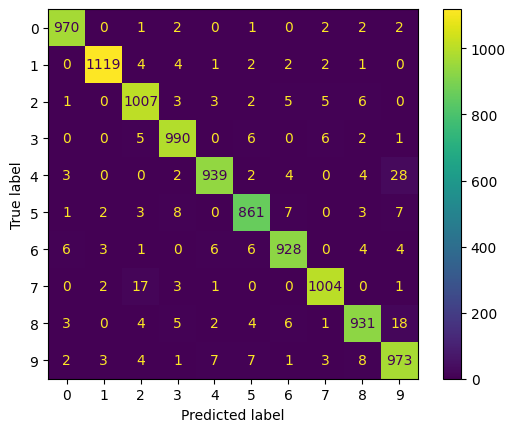

In [25]:
predictions = rf.predict(test_features)
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions)

In [26]:
import sklearn.preprocessing

sc = sklearn.preprocessing.StandardScaler()
train_features_scaled = sc.fit_transform(train_features)
test_features_scaled = sc.fit_transform(test_features)

In [28]:
rf = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 100)
rf.fit(train_features_scaled, train_labels)
print(rf.score(test_features_scaled, test_labels))

0.9725


In [33]:
pca = sklearn.decomposition.PCA(n_components = 128, random_state = 42)
train_features_reduced = pca.fit_transform(train_features_scaled)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
test_features_reduced = pca.transform(test_features_scaled)

Explained variance 0.96
[0.392, 0.131, 0.053, 0.046, 0.036, 0.025, 0.021, 0.018, 0.014, 0.012, 0.011, 0.01, 0.01, 0.008, 0.008, 0.007, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [30]:
rf_reduced = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf_reduced.fit(train_features_reduced, train_labels)
print(rf_reduced.score(test_features_reduced, test_labels))

0.9432


In [31]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 10)
rf.fit(train_features_reduced, train_labels)
print(rf.score(test_features_reduced, test_labels))

0.9401


In [32]:
umap_ = umap.UMAP(n_components = 8, n_jobs = -1)
train_features_reduced = umap_.fit_transform(train_features)
test_features_reduced = umap_.transform(test_features)

KeyboardInterrupt: 

In [38]:
rf_reduced = sklearn.ensemble.RandomForestClassifier(n_jobs = -1, n_estimators = 1000)
rf_reduced.fit(train_features_reduced, train_labels)
print(rf_reduced.score(test_features_reduced, test_labels))

0.4565


In [41]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 1000)
rf.fit(train_features_reduced, train_labels)
print(rf.score(test_features_reduced, test_labels))

0.4196


In [34]:
import torch
import random
RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

device = torch.device("cuda")


train_ds = torch.utils.data.TensorDataset(
    torch.tensor(train_features_scaled, dtype = torch.float),
    torch.tensor(train_labels, dtype = torch.long)
)

test_ds = torch.utils.data.TensorDataset(
    torch.tensor(test_features_scaled, dtype = torch.float),
    torch.tensor(test_labels, dtype = torch.long)
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 1024, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 1024, shuffle = False)

model = torch.nn.Sequential(
    torch.nn.Linear(train_features_scaled.shape[1], 128), torch.nn.BatchNorm1d(128), torch.nn.GELU(),
    torch.nn.Linear(128, 64), torch.nn.BatchNorm1d(64), torch.nn.GELU(),
    torch.nn.Linear(64, 32), torch.nn.BatchNorm1d(32), torch.nn.GELU(),
    torch.nn.Linear(32, 10)
).to(device)

optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 5e-4
)

for epoch in range(50):
    model.train()
    for (X, y) in train_dl:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device), reduction = 'sum')
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        preds = [ ]
        Y = [ ]
        for batch_x, batch_y in test_dl:
            preds.extend(torch.argmax(model(batch_x.to(device)), axis = 1).cpu())
            Y.extend(batch_y)
        accuracy = sklearn.metrics.accuracy_score(Y, preds)

    print(f"epoch {epoch}: loss = {loss.item()}, acc = {accuracy}")

epoch 0: loss = 519.088623046875, acc = 0.9331
epoch 1: loss = 309.5721740722656, acc = 0.9661
epoch 2: loss = 207.8317413330078, acc = 0.9734
epoch 3: loss = 147.201171875, acc = 0.9732
epoch 4: loss = 103.54418182373047, acc = 0.9782
epoch 5: loss = 75.25910949707031, acc = 0.977
epoch 6: loss = 67.66312408447266, acc = 0.9794
epoch 7: loss = 64.28288269042969, acc = 0.979
epoch 8: loss = 55.706424713134766, acc = 0.9785
epoch 9: loss = 49.08966064453125, acc = 0.9817
epoch 10: loss = 38.6754264831543, acc = 0.9794
epoch 11: loss = 46.68344497680664, acc = 0.9785
epoch 12: loss = 33.631378173828125, acc = 0.9777
epoch 13: loss = 30.900978088378906, acc = 0.9808
epoch 14: loss = 31.594947814941406, acc = 0.9783
epoch 15: loss = 35.51460266113281, acc = 0.9828
epoch 16: loss = 29.238981246948242, acc = 0.9792
epoch 17: loss = 21.822174072265625, acc = 0.9804
epoch 18: loss = 19.562084197998047, acc = 0.9819
epoch 19: loss = 15.557062149047852, acc = 0.982
epoch 20: loss = 10.2925958633

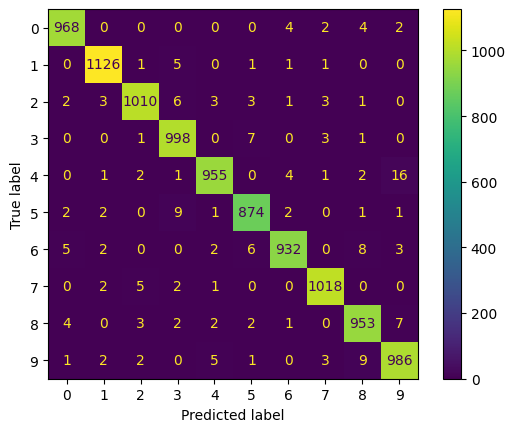

In [35]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, numpy.array(preds))

In [90]:
rf = sklearn.neighbors.KNeighborsClassifier(n_jobs = -1, n_neighbors = 1)
rf.fit(train_features_scaled, train_labels)
print(rf.score(test_features_scaled, test_labels))

0.9448


In [16]:
def calculate_images(diagrams: numpy.ndarray, N: int = 49000):
    images = [ ]
    for i in range(0, len(diagrams), N):
        print(f'Calculating {i} - {i + N}')
        hk = gtda.diagrams.PersistenceImage(sigma = 1.6, n_jobs = -1)
        images.append(
            hk.fit_transform(diagrams[i:i + N])
        )
    return numpy.concatenate(images, axis = 0)

In [22]:
# train_filtration_pis = calculate_images(train_filtration_diagrams[:49000])
# numpy.save("4__train_filtration_pis.npy", train_filtration_pis)

train_filtration_pis = numpy.load("4__train_filtration_pis.npy")
train_filtration_pis.shape

(49000, 2, 100, 100)

In [24]:
test_filtration_pis = calculate_images(test_filtration_diagrams[:4900])
numpy.save("4__test_filtration_pis.npy", test_filtration_pis)

test_filtration_pis = numpy.load("4__test_filtration_pis.npy")
test_filtration_pis.shape

Calculating 0 - 49000


(4900, 2, 100, 100)

In [31]:
def make_images(filtration_pis: numpy.ndarray):
    images = [ ]
    for img_idx in tqdm.trange(len(filtration_pis) // 49, desc = 'combine images'):
        idx1 = 49 * img_idx
        idx2 = 49 * (img_idx + 1)
        images.append(numpy.concatenate(filtration_pis[idx1:idx2], axis = 0))

    return numpy.array(images)

train_images = make_images(train_filtration_pis)
test_images = make_images(test_filtration_pis)

combine images: 100%|██████████| 100/100 [00:00<00:00, 260.12it/s]


In [60]:
import torch
import random

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

device = torch.device("cuda")

train_ds = torch.utils.data.TensorDataset(
    torch.tensor(train_images, dtype = torch.float),
    torch.tensor(train_labels[:1000], dtype = torch.long)
)

test_ds = torch.utils.data.TensorDataset(
    torch.tensor(test_images, dtype = torch.float),
    torch.tensor(test_labels[:100], dtype = torch.long)
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size = 16, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = 16, shuffle = False)

model = torch.nn.Sequential(
    torch.nn.Conv2d(98, 98, kernel_size = 7), torch.nn.BatchNorm2d(98), torch.nn.GELU(), torch.nn.MaxPool2d(3, 3),
    torch.nn.Conv2d(98, 196, kernel_size = 5), torch.nn.BatchNorm2d(196), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(196, 394, kernel_size = 3, dilation = 2), torch.nn.BatchNorm2d(394), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.LazyLinear(1024), torch.nn.BatchNorm1d(1024), torch.nn.GELU(),
    torch.nn.Linear(1024, 200)
).to(device)

optimizer = torch.optim.AdamW(
    params = model.parameters(),
    lr = 1e-4
)

for epoch in range(63):
    model.train()
    for (X, y) in train_dl:
        optimizer.zero_grad()
        pred = model(X.to(device))
        loss = torch.nn.functional.cross_entropy(pred, y.to(device), reduction = 'sum')
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        preds = [ ]
        Y = [ ]
        for batch_x, batch_y in test_dl:
            preds.extend(torch.argmax(model(batch_x.to(device)), axis = 1).cpu())
            Y.extend(batch_y)
        accuracy = sklearn.metrics.accuracy_score(Y, preds)

    print(f"epoch {epoch}: loss = {loss.item()}, acc = {accuracy}")

epoch 0: loss = 15.74434757232666, acc = 0.14
epoch 1: loss = 10.03386116027832, acc = 0.21
epoch 2: loss = 8.581578254699707, acc = 0.17
epoch 3: loss = 10.991872787475586, acc = 0.2
epoch 4: loss = 6.203951835632324, acc = 0.21
epoch 5: loss = 1.505049228668213, acc = 0.17
epoch 6: loss = 0.8678723573684692, acc = 0.21
epoch 7: loss = 0.9153925180435181, acc = 0.22
epoch 8: loss = 1.1510440111160278, acc = 0.2
epoch 9: loss = 2.201138734817505, acc = 0.23
epoch 10: loss = 1.2548195123672485, acc = 0.19
epoch 11: loss = 1.3541066646575928, acc = 0.21
epoch 12: loss = 0.372041791677475, acc = 0.22
epoch 13: loss = 0.13058283925056458, acc = 0.18
epoch 14: loss = 0.15174895524978638, acc = 0.19
epoch 15: loss = 1.630298376083374, acc = 0.15
epoch 16: loss = 0.19768336415290833, acc = 0.2
epoch 17: loss = 2.128767728805542, acc = 0.19


KeyboardInterrupt: 